In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import numpy as np
import random
from options import DefaultConfig
opt = DefaultConfig()
torch.cuda.set_device(opt.gpu_ids)
torch.manual_seed(opt.seed)
torch.cuda.manual_seed(opt.seed)
torch.cuda.manual_seed_all(opt.seed)
np.random.seed(opt.seed)
random.seed(opt.seed)
import sys
import os
import time
import pdb
from models.model import model
import torch
import torchvision
import torchvision.transforms as transforms
from scipy import interpolate
from utils.image_folder import ImageFolder
from utils import utils
from utils.utils import *
import matplotlib.pyplot as plt
from IPython.display import clear_output


Interaction Network: initialising
Propagation Network: initialising


In [3]:
opt.dataroot_train = opt.dataroot + 'train/'
dataset_train = ImageFolder(opt.dataroot_train, opt.num_frames, 
                       transform=transforms.Compose([
                                   transforms.Resize(opt.loadSize),
                                   transforms.CenterCrop(opt.fineSize),
                                   transforms.ToTensor()]))
dataset_loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=opt.batch_size, shuffle=False)
dataset_train_size = len(dataset_train)
print('#training videos = %d' % dataset_train_size)

opt.dataroot_val = opt.dataroot + 'val/'
dataset_val = ImageFolder(opt.dataroot_val, opt.num_frames, 
                       transform=transforms.Compose([
                                   transforms.Resize(opt.loadSize),
                                   transforms.CenterCrop(opt.fineSize),
                                   transforms.ToTensor()]))
dataset_loader_val = torch.utils.data.DataLoader(dataset_val, batch_size=opt.batch_size_val, shuffle=False)
dataset_val_size = len(dataset_val)
print('#validation videos = %d' % dataset_val_size)

#training videos = 40
#validation videos = 10


In [4]:
model = model(opt)
model.setup()

/home/zhangy23/anaconda3/envs/vc/lib/python3.6/site-packages/torch/serialization.py:593: SourceChangeWarning: source code of class 'models.interaction_net.Inet' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/zhangy23/anaconda3/envs/vc/lib/python3.6/site-packages/torch/serialization.py:593: SourceChangeWarning: source code of class 'models.interaction_net.Encoder' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/zhangy23/anaconda3/envs/vc/lib/python3.6/site-packages/torch/serialization.py:593: SourceChangeWarning: source code of class 'models.interaction_net.Decoder' has changed. you can retrieve the original source

[Interaction net] loading Inet sccesses


In [5]:
sys.getsizeof(torch)

80

In [6]:
!nvidia-smi 

Mon May 11 02:09:57 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.59       Driver Version: 440.59       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  On   | 00000000:19:00.0 Off |                  N/A |
| 37%   68C    P2   126W / 250W |   2414MiB / 11019MiB |     21%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  On   | 00000000:1A:00.0 Off |                  N/A |
| 18%   56C    P2    58W / 250W |   1686MiB / 11019MiB |      5%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [7]:
print(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))

2020-05-11 02:09:57


In [8]:
X_val = []
X_train = []

val_losses = []
train_losses = []
val_psnrs = []
train_psnrs = []

total_steps = 0
for epoch in range(opt.epoch_count, opt.niter + opt.niter_decay):
    torch.cuda.empty_cache()
    val_step = 0
    model_index = 0
    for i, data_raw in enumerate(dataset_loader_train):
        total_steps += 1
        val_step += 1
        data_raw = torch.squeeze(data_raw, dim=0)
        # first round estimation without user interaction, turn on evaluation mode
        opt.no_prev = True
        model.val()
        
        data = utils.get_colorization_data(data_raw, opt, p=opt.sample_p)
        data = ToCuda(data)
        data['prev'] = model.run_auto_colour(data)[0].cpu()
        
        # first estimation is used as previous fake_ab, turn on training mode
        model.train()
        opt.no_prev = False
        fam = None
        num_round = np.random.randint(3) + 1 
        for _ in range(num_round):
            # print(_)
            data_cpu = utils.get_colorization_data(data_raw, opt, prev=data['prev'], marks=data['marks'],p=opt.sample_p)
            # max error frame 
            # n = utils.argmax_l2(data_cpu['prev'], data_cpu['ab'])
            # random frame index
            n = np.array(np.random.randint(15))
            data_cpu['marks'][n] = 1
            if(data_cpu is None): 
                continue 
            data = ToCuda(data_cpu)
            data['prev'][n,:,:,:], tr5 = model.run_interaction(data['gray'][n,:,:,:], data['clicks'][n,:,:,:], data['prev'][n,:,:,:], n)
            data['prev'], fam = model.run_propagation(data, n, tr5, fam)
            data['prev'] = data['prev'].detach().cpu()

        if val_step % opt.val_freq == 0:
            print('validation phase')
            val_loss = 0
            val_psnr = 0
            
            model.val()
            for ii, data_raw_val in enumerate(dataset_loader_val):
                data_raw_val = torch.squeeze(data_raw, dim=0)
                # auto colourisartion
                opt.no_prev = True
                data_cpu_val = utils.get_colorization_data(data_raw_val, opt, p=opt.sample_p)
                if(data_cpu_val is None):
                    continue
                data_val = ToCuda(data_cpu_val)
                data_val['prev'] = model.run_auto_colour(data_val)[0].cpu()
                
                # update first colourisation
                opt.no_prev = False
                val_fam = None
                num_round = np.random.randint(3) + 1 
                for _ in range(num_round):
                    # print(_)
                    data_val = utils.get_colorization_data(data_raw, opt, prev=data_val['prev'], marks=data_val['marks'],p=opt.sample_p)
                    # max error frame 
                    # n = utils.argmax_l2(data_cpu['prev'], data_cpu['ab'])
                    # random frame index
                    n = np.array(np.random.randint(15))
                    data_val['marks'][n] = 1
                    data_val = ToCuda(data_val)
                    data_val['prev'][n,:,:,:], tr5 = model.run_interaction(data_val['gray'][n,:,:,:], data_val['clicks'][n,:,:,:], data_val['prev'][n,:,:,:], n)
                    data_val['prev'], val_fam = model.run_propagation(data_val, n, tr5, val_fam)
                    data_val['prev'] = data_val['prev'].detach().cpu()
                
                val_psnr += calc_batch_psnr(data_val['gray'].detach(), data_val['ab'].detach(), data_val['prev'], opt, avg=False) / data_val['prev'].shape[0]
                val_loss += model.total_loss
     
            val_psnrs.append(val_psnr / dataset_val_size)
            val_losses.append(val_loss / dataset_val_size)
            X_val.append(total_steps)
            model.train()
            
            # save model
            model_index += 1
            print('save_model')
            save_model(model.Pnet, opt, epoch, model_index, val_psnr / dataset_val_size)

        if total_steps % opt.print_freq == 0:
            X_train.append(total_steps)
            # loss and PSNR
            train_psnrs.append(calc_batch_psnr(data['gray'].detach(), data['ab'].detach(), data['prev'], opt))
            train_losses.append(model.total_loss / data['gray'].shape[0])
            
            # plot loss and PSNR curve
            clear_output(wait=True)
            plt.figure(1)
            plt.rcParams['figure.dpi'] = 120 
            #plt.ylim([0, .08])
            plt.title('Loss')
            plt.plot(X_train, train_losses, label="Training loss")
            plt.plot(X_val, val_losses, label="Validation loss")
            plt.grid(True)
            plt.legend()
            plt.show()

            plt.figure(2)
            plt.rcParams['figure.dpi'] = 120 
            # plt.ylim([15, 30])
            plt.title('PSNR')
            plt.plot(X_train, train_psnrs, label="Training PSNR")
            plt.plot(X_val, val_psnrs, label="Validation PSNR")
            plt.grid(True)
            plt.legend()
            plt.show()

    np.save('Iter'+str(epoch)+'train_loss.npy', train_losses)
    np.save('Iter'+str(epoch)+'val_loss.npy', val_losses)
    np.save('Iter'+str(epoch)+'train_psnr.npy', train_psnrs)
    np.save('Iter'+str(epoch)+'val_psnrs.npy', val_psnrs)


/home/zhangy23/anaconda3/envs/vc/lib/python3.6/site-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


[MODEL: interaction network] User Interaction on 1
[MODEL: propagation network] >>>>>>>>> 1 to 2
[MODEL: propagation network] >>>>>>>>> 2 to 3


RuntimeError: Trying to backward through the graph a second time, but the buffers have already been freed. Specify retain_graph=True when calling backward the first time.

In [ ]:
#!sudo apt-get install -y psmisc
#!fuser /dev/nvidia*

In [ ]:
#!kill 20457      

26.030855673217914


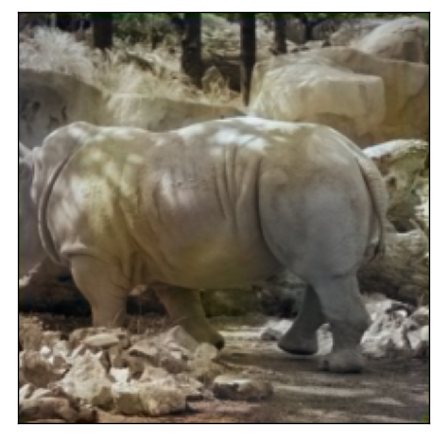

In [33]:
import matplotlib.pyplot as plt 
from skimage.transform import resize
import skimage

lightness = data['gray'].cpu()
real_ab = data['ab'].cpu()
fake_ab = data['prev'].cpu()
fake_img = torch.cat((lightness, fake_ab), 1) 
real_img = torch.cat((lightness, real_ab), 1) 
fake_rgb = lab2rgb(fake_img, opt).detach().numpy()
real_rgb = lab2rgb(real_img, opt).detach().numpy()
idx = 10
img = real_rgb[idx,:,:,:].transpose(1,2,0)
img = fake_rgb[idx,:,:,:].transpose(1,2,0)
img = np.minimum(img, 1)
img = resize(img, (1024, 1024))
skimage.io.imshow(img)
plt.xticks([])
plt.yticks([])
mse = np.mean((fake_rgb[idx, :, :, :] - real_rgb[idx, :, :, :]) ** 2 )
psnr = 10 * np.log10(1.0 / mse)
print(psnr)

In [9]:
val_psnrs

[23.743499755859375,
 10.376237869262695,
 19.23469352722168,
 11.743374824523926,
 24.579273223876953]